<a href="https://colab.research.google.com/github/ayaamr11/Pose-Detection/blob/main/Pose_detection_version1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
#!wget http://arunponnusamy.com/files/mmod_human_face_detector.dat
#!bzip2 -d  '/content/shape_predictor_68_face_landmarks.dat.bz2'

# Imports

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.io
import glob
from pathlib import Path


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

import pickle

import imageio
from mlxtend.image import extract_face_landmarks


# Connect to my drive

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
#!ls "/content/drive/My Drive/Colab Notebooks/machine_learning_projects_data"

# Read data

In [5]:
#unzip folder from drive
!unzip "/content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip"

Archive:  /content/gdrive/MyDrive/Colab Notebooks/machine_learning_projects_data/AFLW2000-3D_.zip
   creating: AFLW2000/
   creating: AFLW2000/Code/
  inflating: AFLW2000/Code/DrawSolidHead.m  
  inflating: AFLW2000/Code/DrawTextureHead.m  
  inflating: AFLW2000/Code/main_show_without_BFM.m  
  inflating: AFLW2000/Code/main_show_with_BFM.m  
   creating: AFLW2000/Code/Mex/
  inflating: AFLW2000/Code/Mex/compile.m  
  inflating: AFLW2000/Code/Mex/Tnorm_Vnorm.h  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.cpp  
  inflating: AFLW2000/Code/Mex/Tnorm_VnormC.mexw64  
   creating: AFLW2000/Code/ModelGeneration/
  inflating: AFLW2000/Code/ModelGeneration/ModelGenerate.m  
  inflating: AFLW2000/Code/ModelGeneration/model_info.mat  
  inflating: AFLW2000/Code/Model_Exp.mat  
  inflating: AFLW2000/Code/Model_Shape_Sim.mat  
  inflating: AFLW2000/Code/NormDirection.m  
  inflating: AFLW2000/Code/readme.txt  
  inflating: AFLW2000/Code/RotationMatrix.m  
  inflating: AFLW2000/Code/Tnorm_VnormC.mex

In [6]:
#read Yaw, Pitch and Roll
def readMat_pose(filename):
    return scipy.io.loadmat(filename)['Pose_Para'][0][0:3] * 180/ math.pi


In [7]:
#read all IMAGE points
def readMat_2d_pts(filename):
    return scipy.io.loadmat(filename)['pt3d_68'][0:2] 


In [8]:
#retrive image poses and points into dataframe
def build_dataFrame():
  xList = []
  yList = []
  imag=['imag_name']
  posList=["pitch","yaw","roll"]
  for i in range(1,69):
    xFeature= "x" + str(i)
    yFeature= "y" + str(i)
    xList.append(xFeature)
    yList.append(yFeature)
  colNames =  xList + yList + posList +imag

  df=pd.DataFrame(columns=colNames)

  for file in glob.glob("/content/AFLW2000/*.mat"):
   #print(file)
   
   pointsList = readMat_2d_pts(file)
   poseList = readMat_pose(file)
   image=file

   record = [*pointsList.flatten().tolist(),*poseList.tolist(),image]
   #print(record)
   df.loc[len(df)] = record
  return df
  

In [9]:
df = build_dataFrame()

In [10]:
df

x1          x2          x3          x4          x5          x6  \
0     209.940048  210.404358  213.663956  216.233856  217.749786  217.572693   
1     108.229164  109.456902  113.467911  118.374466  128.303024  143.724060   
2     302.094025  302.099274  302.239288  299.450623  290.881348  275.444702   
3     162.311554  154.410263  150.267349  144.705750  140.570969  141.398071   
4     164.206070  166.570282  172.253357  178.296600  185.249420  191.978653   
...          ...         ...         ...         ...         ...         ...   
1995  113.007904  114.924492  118.083359  123.336945  134.664383  155.970932   
1996   88.987877  106.105476  125.216988  141.511917  161.414917  187.225784   
1997  118.479767  120.231674  125.183670  130.138031  137.882019  152.445160   
1998  239.207504  252.326965  270.081116  283.315826  290.565857  288.991913   
1999  109.152657  110.409996  114.602203  118.938164  126.666374  143.854950   

              x7          x8          x9         x10  ...         y63  \
0     215.871796  217.174484  230.818146  254.578125  ...  293.536011   
1     162.888474  188.527206  219.918365  246.622406  ...  300.458160   
2     255.313538  235.161606  228.947830  241.464508  ...  293.384827   
3     146.188843  154.854919  180.296722  218.496582  ...  308.637848   
4     198.312683  210.925171  233.487915  260.385406  ...  301.774994   
...          ...         ...         ...         ...  ...         ...   
1995  181.871826  205.207672  224.419418  230.647797  ...  297.116455   
1996  212.860825  244.621002  282.796539  309.773438  ...  298.505066   
1997  169.697327  190.919800  223.536682  256.170624  ...  316.076355   
1998  279.409363  276.840515  300.566711  338.547058  ...  360.535980   
1999  164.687271  188.649704  218.279678  243.380890  ...  310.739014   

             y64         y65         y66         y67         y68      pitch  \
0     293.538025  299.430847  298.362427  299.290314  299.307922   5.052919   
1     300.011627  292.888123  307.587128  309.239319  306.771027  -9.786560   
2     293.263214  302.361633  302.856750  303.337158  302.460052 -18.712811   
3     316.323700  329.735046  325.530334  319.196594  308.948700 -10.114754   
4     301.715332  309.540405  317.322144  319.181030  318.162903   0.349947   
...          ...         ...         ...         ...         ...        ...   
1995  295.314880  292.854675  305.496887  308.252197  308.859314 -21.718952   
1996  291.531555  276.887024  308.653748  316.616028  322.789246 -12.061707   
1997  316.636810  315.942932  315.936401  315.988678  314.783905  -8.579289   
1998  358.584473  351.712158  364.369904  366.716125  364.892029 -35.550888   
1999  310.221344  305.866638  312.579834  313.210419  312.559570 -15.788764   

            yaw       roll                         imag_name  
0     35.609653  -1.982180  /content/AFLW2000/image01238.mat  
1    -13.457857   4.339068  /content/AFLW2000/image02117.mat  
2     80.824234 -20.819366  /content/AFLW2000/image01662.mat  
3     12.041944  19.692764  /content/AFLW2000/image03778.mat  
4     17.553076  -3.432663  /content/AFLW2000/image03614.mat  
...         ...        ...                               ...  
1995 -56.460735   4.982131  /content/AFLW2000/image03249.mat  
1996 -10.180617 -28.413078  /content/AFLW2000/image03823.mat  
1997  -1.148209   2.234392  /content/AFLW2000/image00054.mat  
1998  46.007423 -28.200176  /content/AFLW2000/image02769.mat  
1999 -16.182596   5.527181  /content/AFLW2000/image00046.mat  

[2000 rows x 140 columns]

In [11]:
df[df["imag_name"] =="/content/AFLW2000/image00002.mat"]

x1          x2          x3          x4          x5          x6  \
1643  121.868034  122.367607  126.819237  130.831787  137.523132  148.521729   

              x7          x8          x9         x10  ...         y63  \
1643  161.528015  182.876678  213.940063  248.005371  ...  313.233856   

             y64         y65         y66         y67        y68      pitch  \
1643  315.107117  322.384613  330.965576  330.701965  324.90387 -22.874239   

           yaw      roll                         imag_name  
1643  1.044306  4.908885  /content/AFLW2000/image00002.mat  

[1 rows x 140 columns]

In [12]:
df=df.drop(["imag_name"],axis=1)

# Distribution of outputs

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


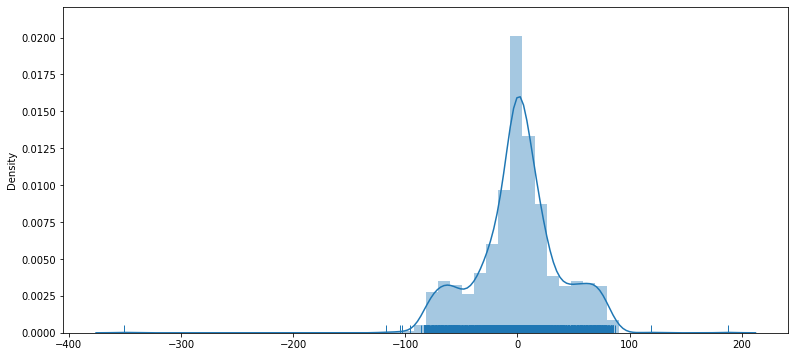

In [13]:
plt.figure(figsize=(13,6))
sns.distplot(df[['yaw']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


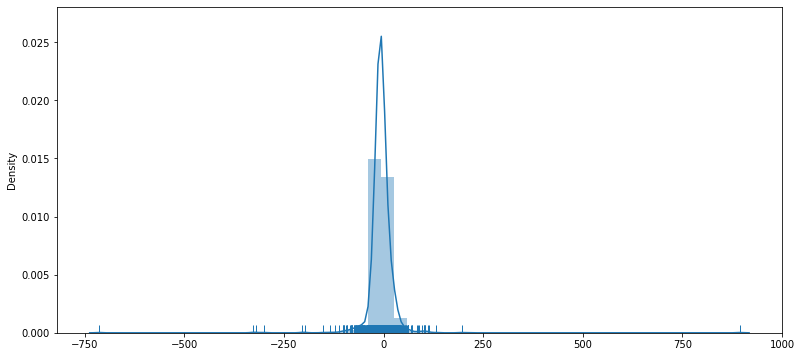

In [14]:
plt.figure(figsize=(13,6))
sns.distplot(df[['pitch']],rug=True)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


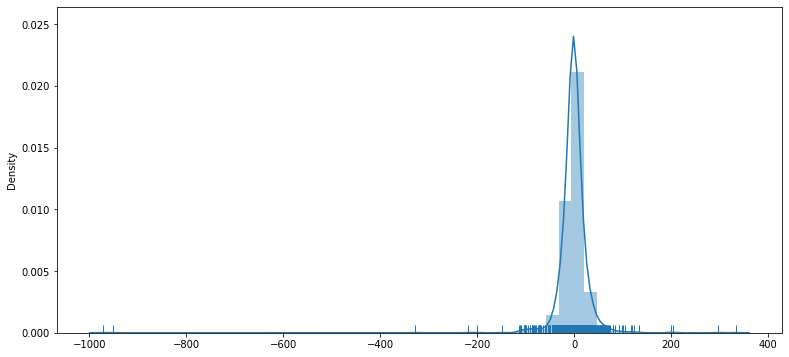

In [15]:
plt.figure(figsize=(13,6))
sns.distplot(df[['roll']],rug=True)
plt.show()

# Split data

In [16]:
out=["yaw","pitch","roll"]

In [17]:
y=df[out]
X=df[df.columns.drop(out)]

In [18]:
y_yaw=y[['yaw']]
y_pitch=y[['pitch']]
y_roll=y[['roll']]

In [19]:
#for multiout models without PCA
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [20]:
#for models with one output without PCA
Xyaw_train, Xyaw_test, yyaw_train, yyaw_test = train_test_split( X, y_yaw, test_size=0.2, random_state=42)
Xpitch_train, Xpitch_test, ypitch_train, ypitch_test = train_test_split( X, y_pitch, test_size=0.2, random_state=42)
Xroll_train, Xroll_test, yroll_train, yroll_test = train_test_split( X, y_roll, test_size=0.2, random_state=42)

# Feature Selection

## Kbest selection on yaw, pitch and roll

In [21]:
selector1 = SelectKBest(score_func=f_regression, k=10)
selector2 = SelectKBest(score_func=f_regression, k=10)
selector3 = SelectKBest(score_func=f_regression, k=10)

XYaw_selected = selector1.fit_transform(Xyaw_train, yyaw_train)
Xpitch_selected = selector2.fit_transform(Xpitch_train, ypitch_train)
XRoll_selected = selector3.fit_transform(Xroll_train, yroll_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
yaw_filter = selector1.get_support()
pitch_filter = selector2.get_support()
roll_filter = selector3.get_support()

features = np.array(X.columns.values)

print(features[yaw_filter],"\n")
print(features[pitch_filter],"\n")
print(features[roll_filter],"\n")

['x3' 'x4' 'x14' 'x15' 'x29' 'x30' 'x31' 'x33' 'x34' 'x35'] 

['y1' 'y2' 'y3' 'y4' 'y29' 'y30' 'y31' 'y33' 'y34' 'y35'] 

['x7' 'x8' 'x9' 'x23' 'x24' 'x25' 'x43' 'x44' 'y10' 'y21'] 



## PCA 

### PCA on all data for multi-output regressors

In [23]:
#PCA on all data
pca_all = PCA(n_components=0.99)
pca_xtrain = pca_all.fit_transform(X_train)
#use tranform only on the test set 
pca_xtest = pca_all.transform(X_test)

### PCA for yaw

In [24]:
#PCA on yaw data
pca_yaw = PCA(n_components=0.99)
pca_xyaw_train = pca_yaw.fit_transform(Xyaw_train)
pca_xyaw_test = pca_yaw.transform(Xyaw_test)

In [25]:
pca_xyaw_train.shape

(1600, 9)

### PCA for pitch

In [26]:
pca_pitch = PCA(n_components=0.99)
pca_xpitch_train = pca_pitch.fit_transform(Xpitch_train)
pca_xpitch_test = pca_pitch.transform(Xpitch_test)

### PCA for roll

In [27]:
pca_roll = PCA(n_components=0.99)
pca_xroll_train = pca_roll.fit_transform(Xroll_train)
pca_xroll_test = pca_roll.transform(Xroll_test)

# Modeling

## MultiOut regressor

In [28]:
shuffeld_xtrain , shuffeld_ytrain = shuffle(pca_xtrain , y_train , random_state=19)

### Using GradientBoostingRegressor

In [29]:
#multiOut_model_one = MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train)
#multiOut_model_two = MultiOutputRegressor(GradientBoostingRegressor(random_state=1,loss='huber',subsample=0.7,criterion='squared_error',n_estimators=150,warm_start=True)).fit(pca_xtrain , y_train)
multiOut_model_gb = MultiOutputRegressor(GradientBoostingRegressor(random_state=1,loss='huber',subsample=0.6,criterion='squared_error',min_samples_leaf=2,warm_start=True,n_estimators=900)).fit(shuffeld_xtrain , shuffeld_ytrain)

In [30]:
#predictions = multiOut_model_one.predict(X_test)
#pca_predictions = multiOut_model_two.predict(pca_xtest)
shuffle_predictions = multiOut_model_gb.predict(pca_xtest)

In [31]:
#print(multiOut_model_one.score(X_train, y_train))
#print(multiOut_model_two.score(pca_xtrain, y_train))
print(multiOut_model_gb.score(shuffeld_xtrain , shuffeld_ytrain))

0.7711729864976515


In [32]:
#print(multiOut_model_one.score(X_test, y_test))
#print(multiOut_model_two.score(pca_xtest, y_test))
print(multiOut_model_gb.score(pca_xtest, y_test))

0.6950400387637171


In [33]:
#print(mean_squared_error(y_test,predictions,multioutput='raw_values'))
#print(mean_squared_error(y_test,pca_predictions,multioutput='raw_values'))
print(mean_squared_error(y_test,shuffle_predictions,multioutput='raw_values'))

[ 14.10288473 174.03253432 494.31009974]


In [34]:
 #impFeatures = permutation_importance(multiOut_model_three,pca_xtrain , y_train ,n_repeats=10,random_state=0)

### using RandomForestRegressor

In [35]:
multiOut_model_rf= MultiOutputRegressor(RandomForestRegressor(random_state=0,bootstrap= True)).fit(shuffeld_xtrain , shuffeld_ytrain)

In [36]:
predictions = multiOut_model_rf.predict(pca_xtest)

In [37]:
print(multiOut_model_rf.score(shuffeld_xtrain , shuffeld_ytrain))
print(multiOut_model_rf.score(pca_xtest, y_test))
print(mean_squared_error(y_test,predictions,multioutput='raw_values'))

0.8850104033676502
0.7817577433764668
[  8.43126027 188.27810126 282.4578205 ]


## **Pitch**

In [107]:
#shuffel data first because it improves accurecy
shuffeld_xpitch_train,shuffeld_pitchtrain = shuffle(pca_xpitch_train,ypitch_train , random_state=19)

### XGBRegressor 

In [39]:
#perform grid search
param = {'nthread':[4],
              'max_depth': [3,4],
              'min_child_weight': [2,4],
              'subsample': [0.5 ,0.7],
              'colsample_bytree': [0.6,0.7,0.8],
              'n_estimators': [500 ,700]}

xgb_gridsearch = GridSearchCV(XGBRegressor(),
                        param,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

In [ ]:
#xgb_gridsearchXGB.fit(pca_xyaw_train,yyaw_train)

#print(xgb_gridsearchXGB.best_score_)
#print(xgb_gridsearchXGB.best_params_)

In [40]:
xgboot_pitchModel = XGBRegressor(n_estimators=300, max_depth=2, subsample=0.7, colsample_bytree=0.8,min_child_weight=4)
xgboot_pitchModel.fit(pca_xpitch_train,ypitch_train)

[17:16:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=2, min_child_weight=4,
             n_estimators=300, subsample=0.7)

In [41]:
predictions = xgboot_pitchModel.predict(pca_xpitch_test)

In [42]:
print(xgboot_pitchModel.score(pca_xpitch_train,ypitch_train))
print(xgboot_pitchModel.score(pca_xpitch_test, ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.891676915008304
0.35742290531275245
433.5440566686451


### RandomForestRegressor

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [9,10,11],
  #  'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [1800,2000,2200],
    'random_state':[7]
}

rf_gridsearch= GridSearchCV( estimator = RandomForestRegressor(), param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True )

In [ ]:
# Fit the grid search to the data
#xgb_gridsearchRF.fit( pca_xyaw_train , yyaw_train )
#xgb_gridsearchRF.best_params_

In [ ]:
randomforest_pitchModel = RandomForestRegressor(random_state=7,bootstrap= True,n_estimators=2500,max_depth=10,)
randomforest_pitchModel.fit( pca_xpitch_train , ypitch_train )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(max_depth=10, n_estimators=2500, random_state=7)

In [ ]:
predictions = randomforest_pitchModel.predict(pca_xpitch_test)

In [ ]:
print(randomforest_pitchModel.score(pca_xpitch_train,ypitch_train))
print(randomforest_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.7984736697521044
0.5721907112882287
376.8049099665425


### DecisionTreeRegressor

In [ ]:
dt_pitchModel = DecisionTreeRegressor(random_state=0, max_depth=4)

In [ ]:
dt_pitchModel.fit(pca_xpitch_train,ypitch_train)
predictions = dt_pitchModel.predict(pca_xpitch_test)

In [ ]:
print(dt_pitchModel.score(pca_xpitch_train,ypitch_train))
print(dt_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.824928382419503
0.36604766215076645
558.3711244458234


### GradientBoostingRegressor

In [165]:
gb_pitchModel = GradientBoostingRegressor(random_state=1,subsample=0.5,criterion='squared_error',min_samples_leaf=2,warm_start=False,n_estimators=700)

In [166]:
gb_pitchModel.fit(shuffeld_xpitch_train,shuffeld_pitchtrain)
predictions = gb_pitchModel.predict(pca_xpitch_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [167]:
print(gb_pitchModel.score(shuffeld_xpitch_train,shuffeld_pitchtrain))
print(gb_pitchModel.score(pca_xpitch_test,ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.9975868644485623
0.7680407855170828
156.5019040673129


In [ ]:
# save the model to disk
# yaw_bestModel = 'yaw_model.sav'
# pickle.dump(gb_yawModel, open(yaw_bestModel, 'wb'))


In [ ]:
# load the model from disk
# loaded_model = pickle.load(open(yaw_bestModel, 'rb'))
# result = loaded_model.score(pca_xyaw_test,yyaw_test)
# print(result)

0.39364753943254627


## **yaw**

### XGBRegressor



In [ ]:
xgboot_pitchModel = XGBRegressor(n_estimators=1000, max_depth=4, subsample=0.7, colsample_bytree=0.8)
xgboot_pitchModel.fit(Xpitch_train,ypitch_train)

[13:52:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.8, max_depth=4, n_estimators=1000,
             subsample=0.7)

In [ ]:
predictions = xgboot_pitchModel.predict(Xpitch_test)

print(xgboot_pitchModel.score(Xpitch_train,ypitch_train))
print(xgboot_pitchModel.score(Xpitch_test, ypitch_test))
print(mean_squared_error(ypitch_test,predictions))

0.9999984893463474
0.598119553017249
353.96736265040033


### random forest regressor (Winner model)

In [ ]:
randomforest_yawModel =  RandomForestRegressor(random_state=42)
randomforest_yawModel.fit(pca_xyaw_train,yyaw_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestRegressor(random_state=42)

In [ ]:
predictions = randomforest_yawModel.predict(pca_xyaw_test)

print("train score: ",randomforest_yawModel.score(pca_xyaw_train,yyaw_train))
print("test score: ",randomforest_yawModel.score(pca_xyaw_test,yyaw_test))
print("mean squared error: ",mean_squared_error(yyaw_test,predictions))

0.9859067466738026
0.9864207881282705
19.851172450794607


## **Roll**

### random search for RandomForestRegressor

In [ ]:
#n_estimators = [200,500,700,1000,1200]
#
#max_features = ['auto', 'sqrt']
#
#max_depth = [10,30,50,80,100]
#max_depth.append(None)
#
#min_samples_split = [2, 5, 10]
#
#min_samples_leaf = [1, 2, 4]
#
#bootstrap = [True, False]
#
#random_grid = {'n_estimators': n_estimators,
#               'max_features': max_features,
#               'max_depth': max_depth,
#               'min_samples_split': min_samples_split,
#               'min_samples_leaf': min_samples_leaf,
#               'bootstrap': bootstrap}
#print(random_grid)

In [ ]:
#rf = RandomForestRegressor()
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
#rf_random.fit(pca_xroll_train , yroll_train)

In [ ]:
#rf_random.best_params_

### grid search for RandomForestRegressor

In [122]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,6],
    'max_features': [2,3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10 ],
    'n_estimators': [100, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = 5, verbose = True)


In [ ]:
# Fit the grid search to the data
# grid_search.fit(pca_xroll_train , yroll_train)
# grid_search.best_params_

In [172]:
randomforest_rollModel =   RandomForestRegressor(random_state=1,bootstrap= True,n_estimators=2000,max_depth=10,min_samples_split=4,min_samples_leaf=3,max_features=7)
# random_state=0, bootstrap=False, max_depth=6,
# max_features=5, min_samples_leaf=1,
# min_samples_split=8, n_estimators=300
randomforest_rollModel.fit(pca_xroll_train , yroll_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(max_depth=10, max_features=7, min_samples_leaf=3,
                      min_samples_split=4, n_estimators=2000, random_state=1)

In [173]:
predictions = randomforest_rollModel.predict(pca_xroll_test)

print(randomforest_rollModel.score(pca_xroll_train,yroll_train))
print(randomforest_rollModel.score(pca_xroll_test,yroll_test))
print(mean_squared_error(yroll_test,predictions))

0.6907700367727927
0.6253891777099857
286.56834744822294


# Test performance on imageS

## Extract 68 points

In [ ]:
img = imageio.imread('/content/gdrive/MyDrive/photos/IMG-20210318-WA0107.jpg')
landmarks = extract_face_landmarks(img)
print(landmarks.shape)

(68, 2)


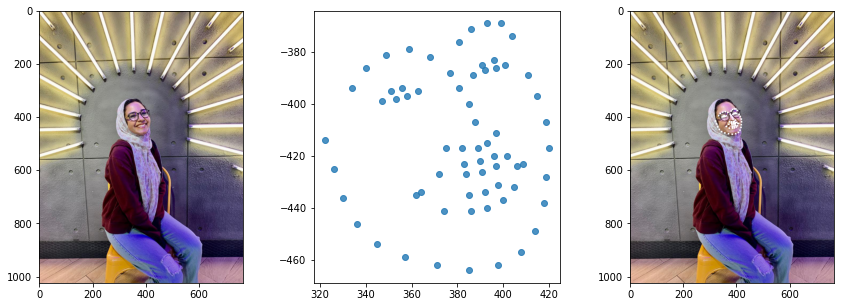

In [ ]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img)
ax = fig.add_subplot(1, 3, 2)
ax.scatter(landmarks[:, 0], -landmarks[:, 1], alpha=0.8)
ax = fig.add_subplot(1, 3, 3)
img2 = img.copy()

for p in landmarks:
    img2[p[1]-3:p[1]+3, p[0]-3:p[0]+3, :] = (255, 255, 255)

ax.imshow(img2)
plt.show()

In [ ]:
x_img = (landmarks[:,0])
y_img = (landmarks[:,1])


In [ ]:
features = np.concatenate((x_img,y_img))
features = features.reshape(1,-1)
features.shape

(1, 136)

##  Prepare features

In [ ]:
poses_features = pca_all.transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
yaw_features = pca_yaw.transform(features)
pitch_features = pca_pitch.transform(features)
roll_features = pca_roll.transform(features)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  "X does not have valid feature names, but"


## Test on best models 

In [ ]:
pred = multiOut_model_gb.predict(poses_features)

In [ ]:
pred

array([[ 53.46928272,  19.59500532, -75.78525643]])

In [ ]:
predicted_pitch = gb_pitchModel.predict(pitch_features)
predicted_yaw= randomforest_yawModel.predict(yaw_features)
predicted_roll= randomforest_rollModel.predict(roll_features)

In [ ]:
print(predicted_yaw)
print(predicted_pitch)
print(predicted_roll)
#range of yaw,pitch,and roll should be between -180 and 180

[72.53383331]
[64.22784352]
[-51.05132818]
